In [4]:
print("""
@File         : ch08_accounting_for_seasonality.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-03-28 21:12:06
@Email        : cuixuanstephen@gmail.com
@Description  : 考虑季节性因子
""")


@File         : ch08_accounting_for_seasonality.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-03-28 21:12:06
@Email        : cuixuanstephen@gmail.com
@Description  : 考虑季节性因子



In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Examining the $SARIMA(p,d,q)(P,D,Q)_m$ model

参数 $m$ 代表频率。在时间序列的背景下，频率定义为每个周期的观测数。对于每年、每季度、每月或每周记录的数据，一个周期的长度可以被视为 1 年。如果数据每年记录一次，则 $m = 1$，因为每年只有一次观察。如果数据按季度记录，则 $m = 4$，因为一年有四个季度，因此每年有四个观测值。当然，如果数据是每月记录的，则 $m = 12$。最后，对于每周数据，$m = 52$。**主要是季节性因子的长度内有多少条观测数据**

|Data |collection|
|----|----|
|Frequency |m|
|Annual |1|
|Quarterly |4|
|Monthly |12|
|Weekly |52|

当每天或次日收集数据时，有多种解释频率的方法。例如，每日数据可以具有每周季节性。在这种情况下，频率为 $m = 7$，因为在 1 周的完整周期内将有 7 个观测值。它还可能具有每年的季节性，这意味着 $m = 365$。因此，您可以看到每日和次每日数据可以具有不同的周期长度，因此具有不同的频率 $m$。

|Data collection|Frequency m|||||
|----|----|----|----|----|----|
||Minute|Hour|Day|Week|Year
Daily||||7|365
Hourly|||24|168|8766
Every minute||60|1440|10080|525960
Every second|60|3600|86400|604800|31557600

**Seasonal autoregressive integrated moving average (SARIMA) model**

The seasonal autoregressive integrated moving average (SARIMA) model adds seasonal parameters to the ARIMA(p,d,q) model. It is denoted as SARIMA(p,d,q)(P,D,Q)m, where P is the order of the seasonal AR(P) process, D is the seasonal order of integration, Q is the order of the seasonal MA(Q) process, and m is the frequency, or the number of observations per seasonal cycle. Note that a SARIMA(p,d,q)(0,0,0)m model is equivalent to an ARIMA(p,d,q) model.

让我们考虑一个 $m = 12$ 的示例。如果 $P = 2$，这意味着我们以 $m$ 倍数的滞后值包含该序列的两个过去值。因此，我们将包含 $y_t – 12$ 和 $y_t – 24$ 处的值。

同样，如果 $D = 1$，这意味着季节性差异使序列平稳

$$y_t^{'} = y_t – y_{t–12}$$

在 $Q = 2$ 的情况下，我们将包含 $m$ 倍数滞后的过去误差项。因此，我们将包含误差 $\epsilon_{t–12}$ 和 $\epsilon_{t–24}$。

In [6]:
df = pd.read_csv('../data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


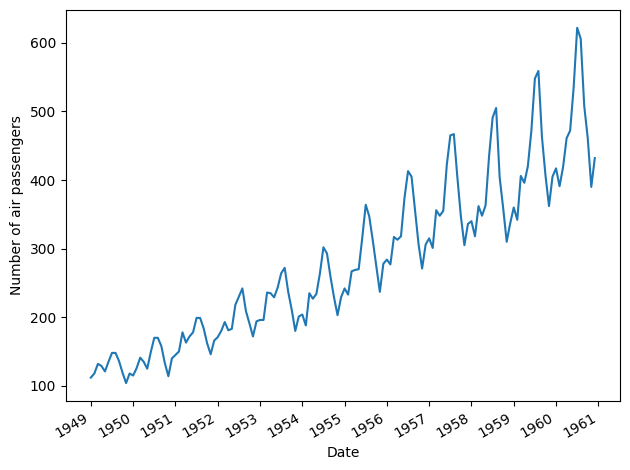

In [7]:
fig, ax = plt.subplots()
ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F01.png', dpi=300)

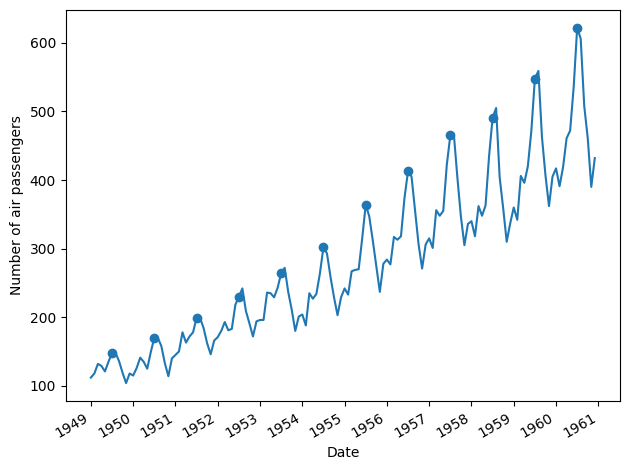

In [8]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F02_peixeiro.png', dpi=300)

## 识别时间序列中的季节性模式

通常，绘制时间序列数据足以观察周期性模式。

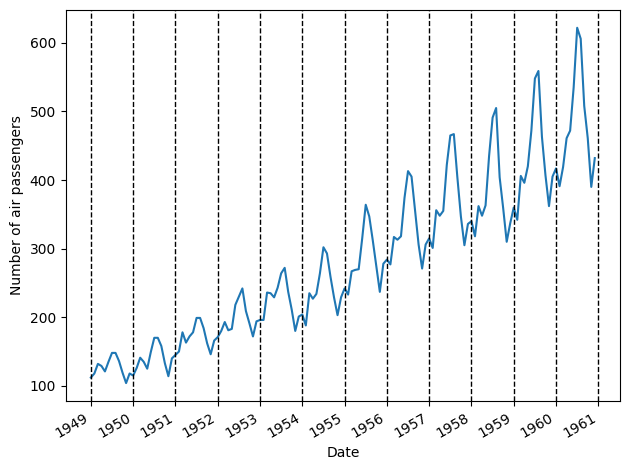

In [9]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F03.png', dpi=300)

识别时间序列中季节性模式的另一种方法是使用时间序列分解。

**时间序列分解**

时间序列分解是一项统计任务，它将时间序列分为三个主要组成部分：趋势成分、季节性成分和残差。

趋势成分代表时间序列的长期变化，该部分负责随时间增加或减少的时间序列。季节性成分是时间序列中的周期性模式，它代表在固定时间内发生的重复波动。最后，残差或噪声表示无法用趋势或季节性成分解释的任何不规则性。

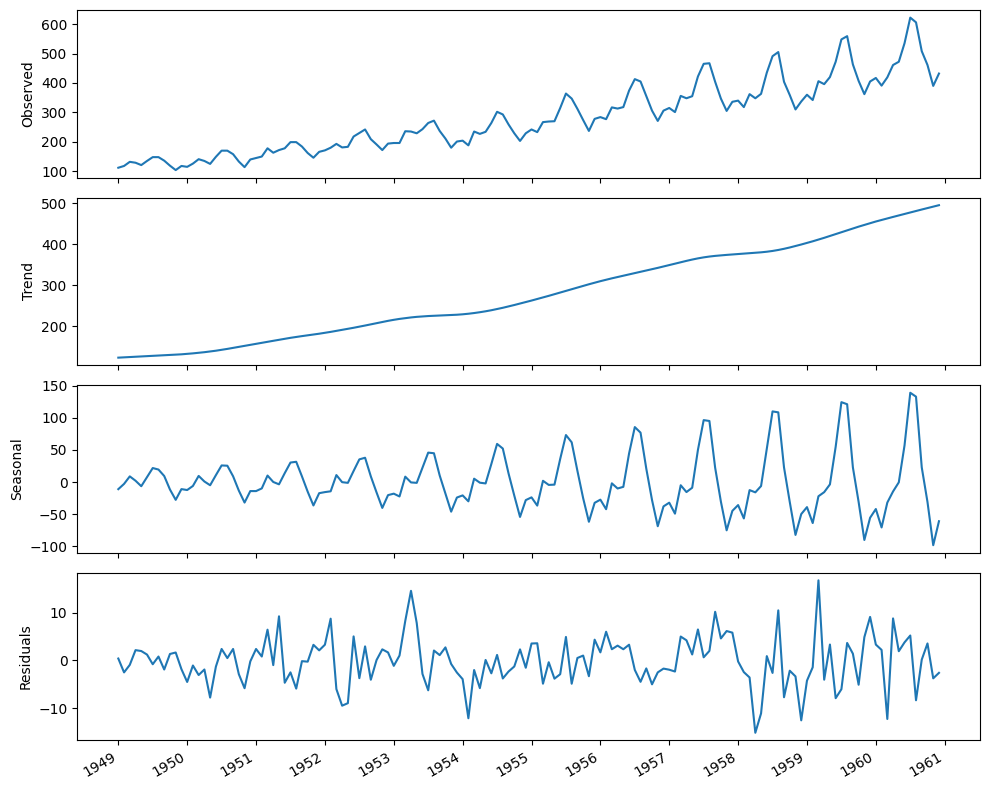

In [10]:
decompositions = STL(df['Passengers'], period=12).fit()

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axes[0].plot(decompositions.observed)
axes[0].set_ylabel('Observed')
axes[1].plot(decompositions.trend)
axes[1].set_ylabel('Trend')
axes[2].plot(decompositions.seasonal)
axes[2].set_ylabel('Seasonal')
axes[3].plot(decompositions.resid)
axes[3].set_ylabel('Residuals')
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
fig.autofmt_xdate()
plt.tight_layout()

在我们的时间序列没有季节性模式的情况下，分解过程将在 0 处显示季节性分量的水平线。

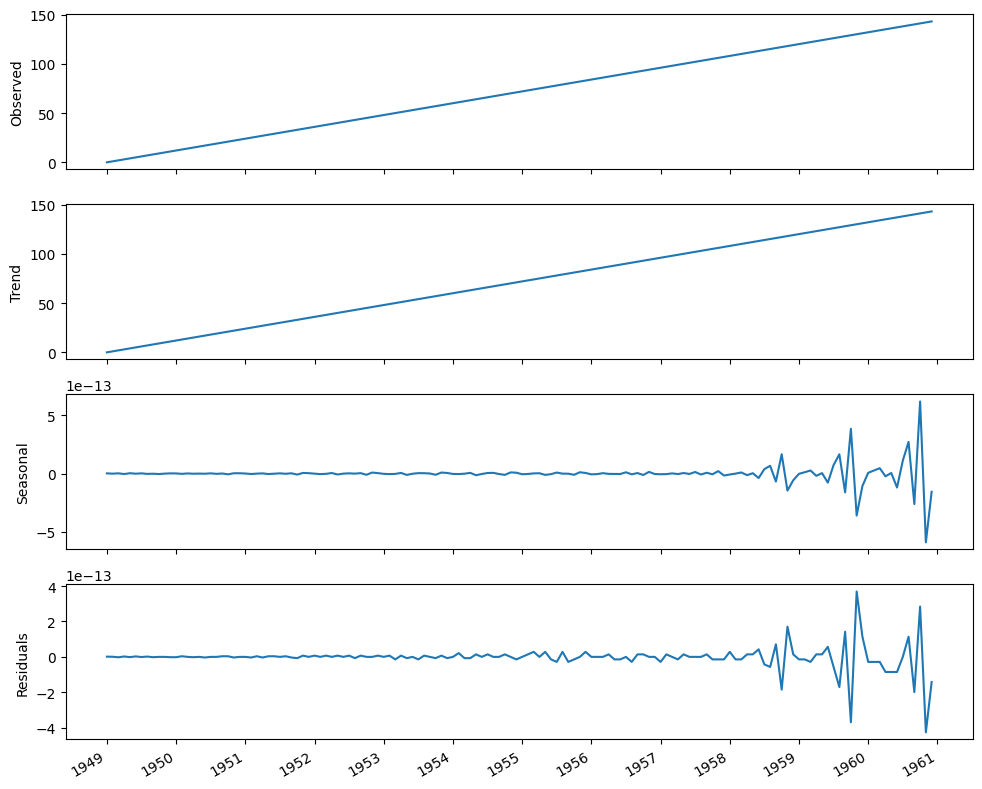

In [16]:
linear_ts = np.arange(0, 144)
decomposition = STL(linear_ts, period=12).fit()
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axes[0].plot(decomposition.observed)
axes[0].set_ylabel('Observed')
axes[1].plot(decomposition.trend)
axes[1].set_ylabel('Trend')
axes[2].plot(decomposition.seasonal)
axes[2].set_ylabel('Seasonal')
axes[3].plot(decomposition.resid)
axes[3].set_ylabel('Residuals')
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH08_F05.png', dpi=300)

In [18]:
np.allclose(decomposition.seasonal, 0)

True

随机加点扰动，发现竟然可以识别出季节模型，这不太合理

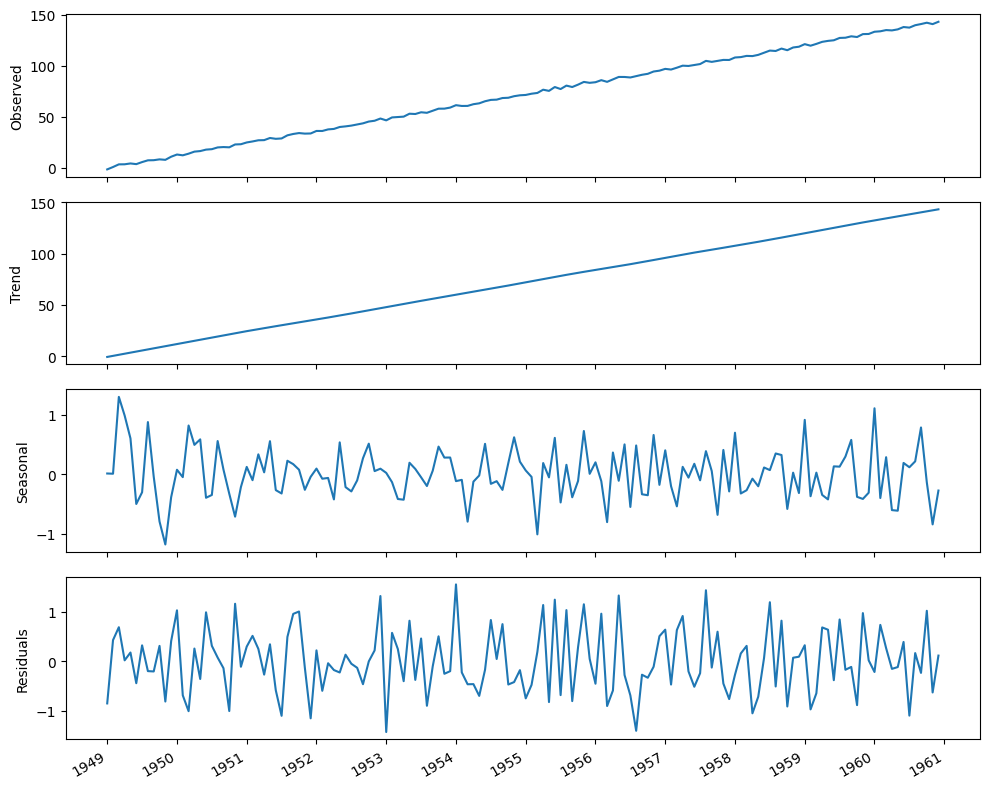

In [20]:
linear_ts = np.arange(0, 144) + np.random.standard_normal(144)
decomposition = STL(linear_ts, period=12).fit()
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axes[0].plot(decomposition.observed)
axes[0].set_ylabel('Observed')
axes[1].plot(decomposition.trend)
axes[1].set_ylabel('Trend')
axes[2].plot(decomposition.seasonal)
axes[2].set_ylabel('Seasonal')
axes[3].plot(decomposition.resid)
axes[3].set_ylabel('Residuals')
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
fig.autofmt_xdate()
plt.tight_layout()

## 利用季节性模式来进行预测